# Code for the Project of Group G01-H 

# Imports/Packages

In [1]:
# standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data split and standardizing(/scaling)
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV #je nachdem ob wir KFold brauchen, das weglassen
from sklearn.preprocessing import StandardScaler
# the 4 learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
    # for decision trees see: https://scikit-learn.org/stable/modules/tree.html
from sklearn.svm import SVC, NuSVC, LinearSVC
    # for svm we have different methods see: https://scikit-learn.org/stable/modules/svm.html
# metrics
from sklearn.metrics import r2_score, mean_squared_error, roc_curve, confusion_matrix, auc
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
#Label encoder
from sklearn.preprocessing import LabelEncoder
# other
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.combine import SMOTEENN


import warnings

warnings.filterwarnings('ignore')

# Functions

In [2]:
# Utility function to plot the diagonal line
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

def evaluation_metrics(clf, y, X,legend_entry='my legendEntry'):
    """
    compute multiple evaluation metrics for the provided classifier given the true labels
    and input features. Provides a plot of the roc curve on the given axis with the legend
    entry for this plot being specified, too.

    :param clf: classifier method
    :type clf: numpy array

    :param y: true class labels
    :type y: numpy array

    :param X: feature matrix
    :type X: numpy array

    :param ax: matplotlib axis to plot on
    :type legend_entry: matplotlib Axes

    :param legend_entry: the legend entry that should be displayed on the plot
    :type legend_entry: string

    :return: confusion matrix comprising the
             true positives (tp),
             true negatives  (tn),
             false positives (fp),
             and false negatives (fn)
    :rtype: four integers
    """

    # Get the label predictions
    y_test_pred    = clf.predict(X)

    # Calculate the confusion matrix given the predicted and true labels
    tn, fp, fn, tp = confusion_matrix(y, y_test_pred).ravel()
    
    print(':) Successfully implemented the confusion matrix!')

    print('Confusion matrix:\n\t  |y_true = 0\t|y_true = 1')
    print('----------|-------------|------------')
    print('y_pred = 0|  ' + str(tn) + '\t|' + str(fn))
    print('y_pred = 1|  ' + str(fp) + '\t\t|' + str(tp))
    
    confusion_matrix_values = np.array([[tn, fp], [fn, tp]])

    # Create a heatmap using seaborn
    ax = sns.heatmap(confusion_matrix_values, annot=True, fmt="d", cmap="Blues", cbar=True)

    # Set labels, title, and ticks
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(["Negative", "Positive"])
    ax.yaxis.set_ticklabels(["Negative", "Positive"])

    # Show the plot
    plt.show()

    # Check for denominator of zero
    def safe_divide(numerator, denominator):
        return numerator / denominator if denominator != 0 else 0

    # Calculate the evaluation metrics
    precision = safe_divide(tp, (tp + fp))
    recall = safe_divide(tp, (tp + fn))
    f1_score = safe_divide((tp), (tp + (0.5*(fn + fp))))
    specificity = safe_divide(tn, (tn + fp))
    accuracy = safe_divide((tp+tn), (tp + tn + fp + fn))

    # Get the roc curve using a sklearn function
    #y_test_predict_proba  = clf.predict_proba(X)
    #fp_rates, tp_rates, _ = roc_curve(y, y_test_predict_proba[:,1]) # i want the predictioin probability for the class "1"

    # Calculate the area under the roc curve using a sklearn function
    #roc_auc = auc(fp_rates, tp_rates)

    # Plot on the provided axis - feel free to make this plot nicer if
    # you want to.
    #ax.plot(fp_rates, tp_rates, label = 'Fold {}'.format(legend_entry))
    #plt.show()

    return [accuracy, precision, recall, specificity, f1_score]

# Import data

In [3]:
data = pd.read_csv(
    filepath_or_buffer='../data/healthcare-dataset-stroke-data.csv',
    index_col='id',
    dtype= {'gender':object, 'age':float, 'hypertension':bool, 'heart_disease':bool,
            'ever_married':object, 'work_type':object, 'Residence_type':object, 
            'avg_glucose_level':float, 'bmi':float, 'smoking_status':object, 'stroke':bool}
            )

In [4]:
display(data)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,False,True,Yes,Private,Urban,228.69,36.6,formerly smoked,True
51676,Female,61.0,False,False,Yes,Self-employed,Rural,202.21,NaN,never smoked,True
31112,Male,80.0,False,True,Yes,Private,Rural,105.92,32.5,never smoked,True
60182,Female,49.0,False,False,Yes,Private,Urban,171.23,34.4,smokes,True
1665,Female,79.0,True,False,Yes,Self-employed,Rural,174.12,24.0,never smoked,True
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,True,False,Yes,Private,Urban,83.75,NaN,never smoked,False
44873,Female,81.0,False,False,Yes,Self-employed,Urban,125.20,40.0,never smoked,False
19723,Female,35.0,False,False,Yes,Self-employed,Rural,82.99,30.6,never smoked,False


In [5]:
sum(data['stroke'])

249

# Define datatypes

In [6]:
#as categorical if needed
data['gender'] = pd.Categorical(data['gender'])
data['work_type'] = pd.Categorical(data['work_type'])
data['Residence_type'] = pd.Categorical(data['Residence_type'])
data['smoking_status'] = pd.Categorical(data['smoking_status'])

#change 'ever_married' to boolean
data['ever_married'] = data['ever_married'].map({'Yes': True, 'No': False})
data['ever_married']=data['ever_married'].astype(bool)

# Data description

In [7]:
# Shape and meaning of dataframe -- df.info(), df.shape[], df.columns, df.head()
data.info()
print('There are ', data.shape[1],'columns in the data.')
print('There are ', data.shape[0],'rows in the data.')

#data.columns not necessary because already included in data.info()

# Datatypes -- df.info() and df.dtypes
#data.dtypes not necessary because already included in data.info()

# Missing Data -- df.isna().sum()
print('missing values:')
print(data.isna().sum()) ###bmi has 201 missing values
# Calculate the mean or median of the "bmi" feature
bmi_mean = data['bmi'].mean()
bmi_median = data['bmi'].median()
print(bmi_mean)
print(bmi_median)
# Replace the missing values with the mean or median
data['bmi'].fillna(bmi_mean, inplace=True) 
print(data.isna().sum())

# Brief summary of extremes/means/medians -- df.describe()
print(data.describe())

# Check for duplicate rows -- df.duplicated()
print('sum of duplicated lines is:', data.duplicated().sum()) #marks all duplicates except the first occurence

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             5110 non-null   category
 1   age                5110 non-null   float64 
 2   hypertension       5110 non-null   bool    
 3   heart_disease      5110 non-null   bool    
 4   ever_married       5110 non-null   bool    
 5   work_type          5110 non-null   category
 6   Residence_type     5110 non-null   category
 7   avg_glucose_level  5110 non-null   float64 
 8   bmi                4909 non-null   float64 
 9   smoking_status     5110 non-null   category
 10  stroke             5110 non-null   bool    
dtypes: bool(4), category(4), float64(3)
memory usage: 200.3 KB
There are  11 columns in the data.
There are  5110 rows in the data.
missing values:
gender                 0
age                    0
hypertension           0
heart_disease          0
eve

# Data manipulation

In [8]:
# Identify the categorical (cat_cols), numerical features (num_cols) and boolean features (boolean_cols)
num_cols = ['age', 'avg_glucose_level', 'bmi']
cate_cols = ['gender', 'work_type', 'Residence_type', 'smoking_status']
boolean_cols = ['hypertension', 'heart_disease', 'ever_married', 'stroke']

# Convert boolean columns to integers (0 or 1)
data[boolean_cols] = data[boolean_cols].astype(int)

# This replaces the categorical columns with their corresponding encoded numerical values
label_encoder = LabelEncoder()
for col in cate_cols:
    data[col] = label_encoder.fit_transform(data[col])

#I dont know if the mapping is important but it could be because some machine learning algorithms can interprete data better with mapping but i am not to familiar with this point. 
for col in boolean_cols:
    unique_values = data[col].unique()
    #mapping = {value: index for index, value in enumerate(unique_values)}
    mapping = {value: int(value) for value in unique_values}
    data[col] = data[col].map(mapping)
    
# This helps that no more columns are created than before
columns_to_keep = num_cols + cate_cols + boolean_cols
data_e = data[columns_to_keep]

In [9]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
51676,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
31112,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
60182,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
1665,0,79.0,1,0,1,3,0,174.12,24.000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,0,80.0,1,0,1,2,1,83.75,28.893237,2,0
44873,0,81.0,0,0,1,3,1,125.20,40.000000,2,0
19723,0,35.0,0,0,1,3,0,82.99,30.600000,2,0


# Data Visualization

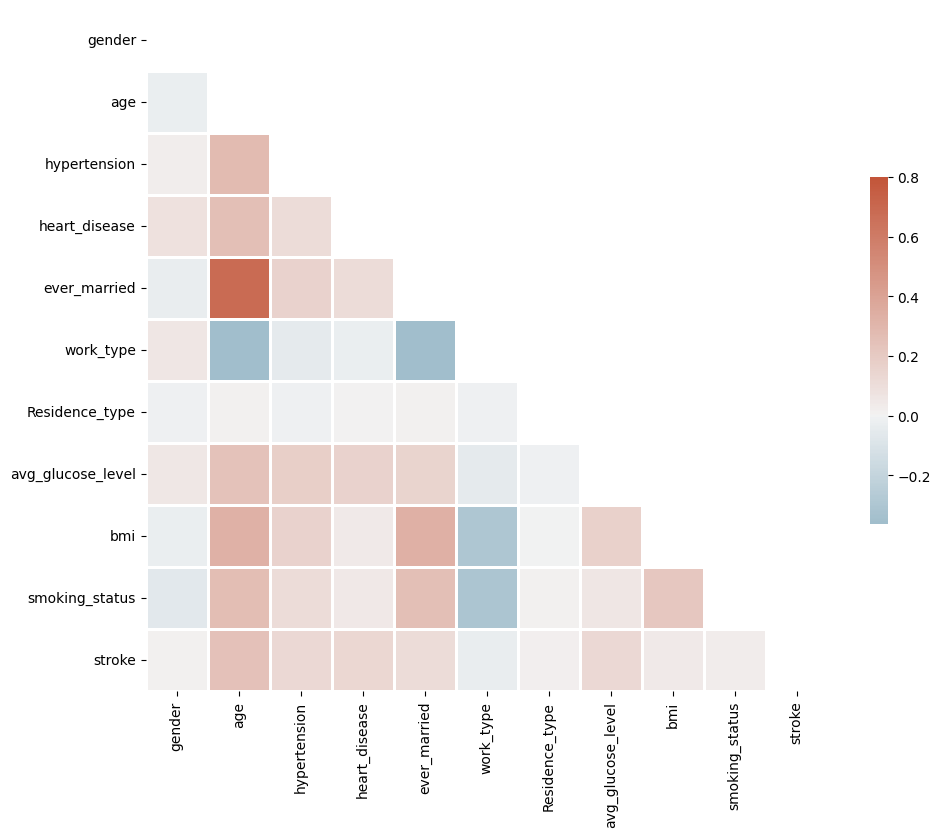

In [10]:
# compute the correlation matrix
correlation = data.corr()
mask = np.triu(np.ones_like(correlation,dtype = bool))
fig, ax = plt.subplots(figsize = (11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.8, center=0, square=True, linewidths=.8, cbar_kws={'shrink':.5})
plt.savefig("../output/correlation_matrix.pdf", backend="pdf", dpi = 300, bbox_inches='tight')

# Feature selection

In [11]:
df = data.drop('ever_married', axis = 1)

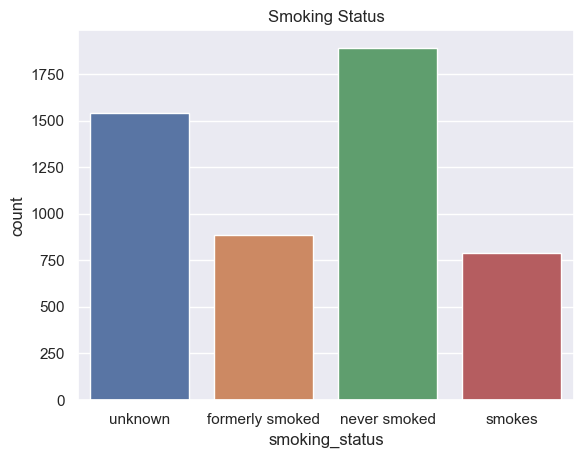

In [12]:
#print(data.smoking_status.value_counts())
sns.set_theme(style='darkgrid')
ax = sns.countplot(data=data, x = 'smoking_status')
xtick_labels = ['unknown', 'formerly smoked', 'never smoked', 'smokes']
# Set x-tick labels
ax.set_xticklabels(xtick_labels)
ax.set_title('Smoking Status')
plt.show()

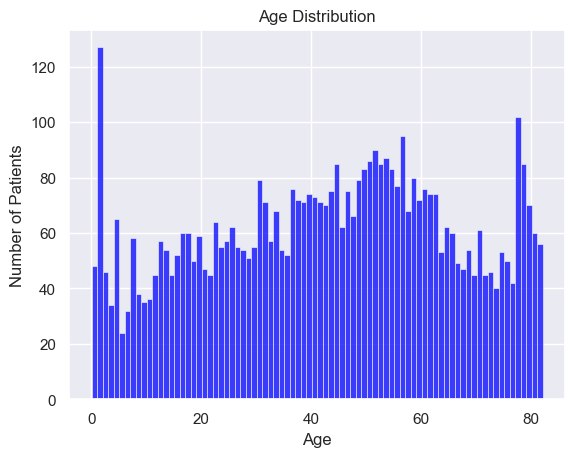

In [13]:
age_distribution = sns.histplot(x = data['age'], color = 'blue', bins=1, binwidth=1)
age_distribution.set(xlabel = 'Age', ylabel = 'Number of Patients', title = 'Age Distribution')
plt.grid(True)
age_distribution.set_axisbelow(True)
age_distribution.set_zorder(-1)

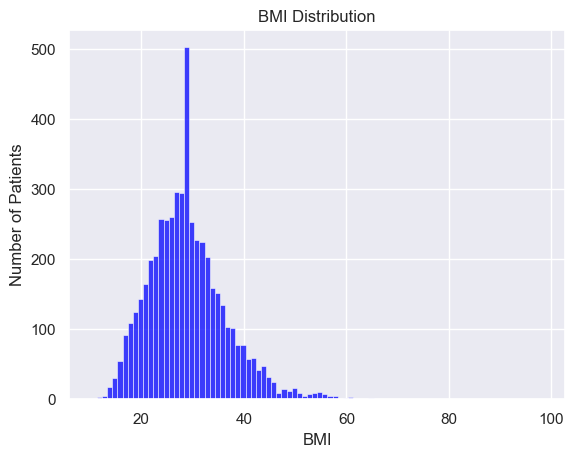

In [14]:
bmi_distribution = sns.histplot(x = data['bmi'], color = 'blue', bins=1, binwidth=1)
bmi_distribution.set(xlabel = 'BMI', ylabel = 'Number of Patients', title = 'BMI Distribution')
plt.grid(True)
bmi_distribution.set_axisbelow(True)
bmi_distribution.set_zorder(-1)

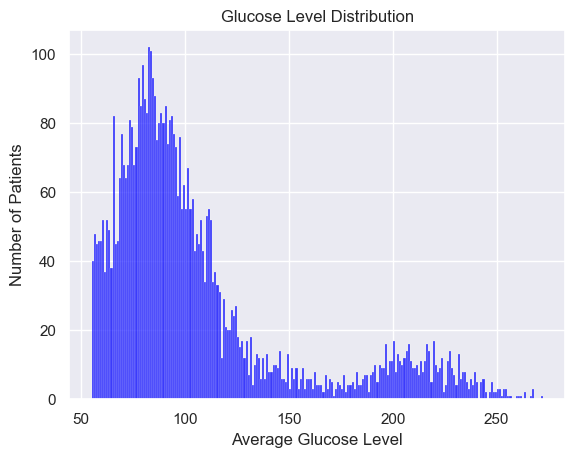

In [15]:
glucose_level_distribution = sns.histplot(x = data['avg_glucose_level'], color = 'blue', bins=1, binwidth=1)
glucose_level_distribution.set(xlabel = 'Average Glucose Level', ylabel = 'Number of Patients', title = 'Glucose Level Distribution')
plt.grid(True)
glucose_level_distribution.set_axisbelow(True)
glucose_level_distribution.set_zorder(-1)

# Data split

In [16]:
X = df.copy().drop(columns='stroke')
y = df['stroke']

# Normal Split or K-Fold?

In [17]:
class_counts = df['stroke'].value_counts()
class_proportions = df['stroke'].value_counts(normalize=True)

print("Class Counts:")
print(class_counts)

print("\nClass Proportions:")
print(class_proportions)

Class Counts:
0    4861
1     249
Name: stroke, dtype: int64

Class Proportions:
0    0.951272
1    0.048728
Name: stroke, dtype: float64


So we can see there are 4861 of non-stroke and 249 with stroke. So the majority has no stroke. In the class proportions we can see the porportion of 'Flase' is 0.9513 --> 95.13% of the data. The porportion of 'True' is 0.0487 --> 4.87% of the data
==>highly imbalanced: So stratified K-Fold Cross-Valdidator would be the better option

# Balance the data

In [20]:
#With the help of Smote we perform a resampling
# Perform resampling
sampler = SMOTEENN(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

# Check the class distribution after resampling
print(pd.Series(y_resampled).value_counts())

1    4565
0    3642
Name: stroke, dtype: int64


# SStratified K-fold cross validator

In [23]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
best_params_list = []

# Model

:) Successfully implemented the confusion matrix!
Confusion matrix:
	  |y_true = 0	|y_true = 1
----------|-------------|------------
y_pred = 0|  678	|78
y_pred = 1|  53		|213


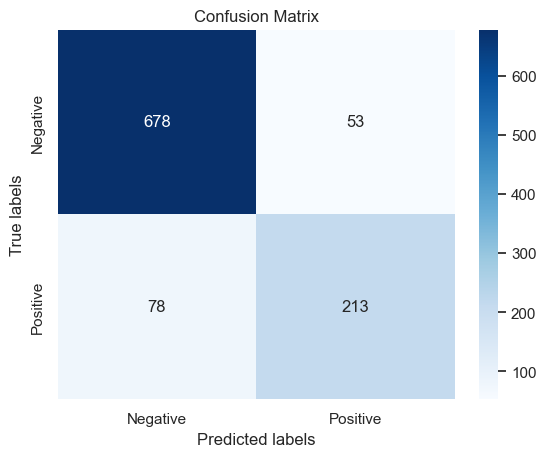

:) Successfully implemented the confusion matrix!
Confusion matrix:
	  |y_true = 0	|y_true = 1
----------|-------------|------------
y_pred = 0|  681	|66
y_pred = 1|  69		|206


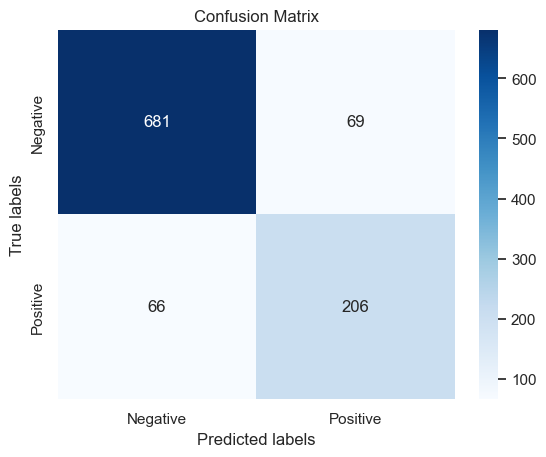

:) Successfully implemented the confusion matrix!
Confusion matrix:
	  |y_true = 0	|y_true = 1
----------|-------------|------------
y_pred = 0|  666	|70
y_pred = 1|  65		|221


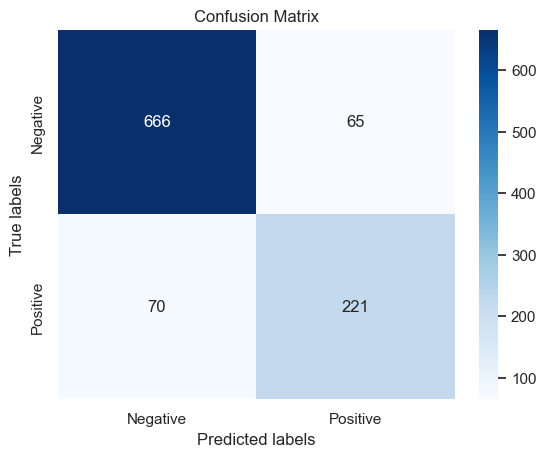

:) Successfully implemented the confusion matrix!
Confusion matrix:
	  |y_true = 0	|y_true = 1
----------|-------------|------------
y_pred = 0|  643	|89
y_pred = 1|  62		|228


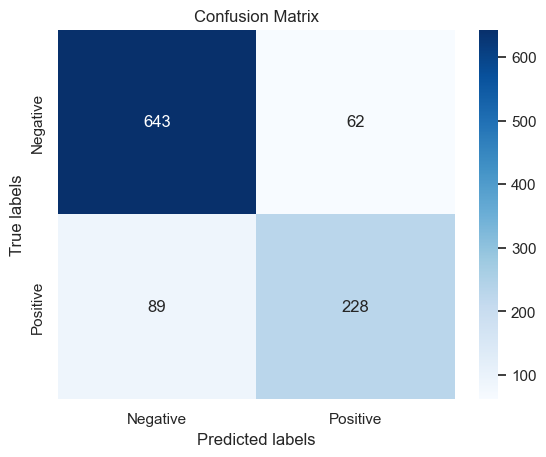

:) Successfully implemented the confusion matrix!
Confusion matrix:
	  |y_true = 0	|y_true = 1
----------|-------------|------------
y_pred = 0|  662	|66
y_pred = 1|  63		|231


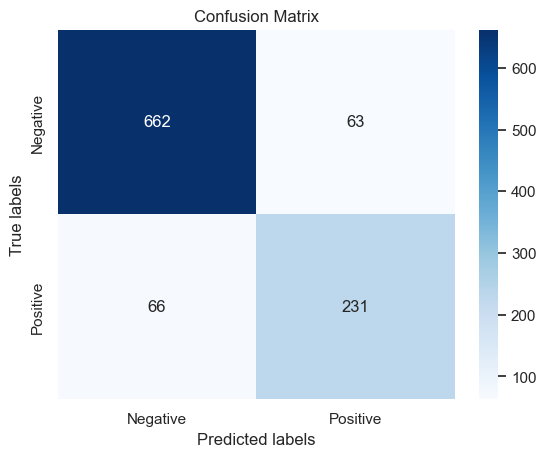

In [24]:
#Prepare the performance overview data frame
df_performance = pd.DataFrame(columns = ['fold','clf','accuracy','precision','recall',
                                         'specificity','F1'])

all_importance = pd.DataFrame(index=range(0, 5), columns=X.columns)

# Use this counter to save your performance metrics for each crossvalidation fold
# also plot the roc curve for each model and fold into a joint subplot
fold = 0

# Be careful that we have different names for our different dataframes (e.g. X_train_LR and X_train_RF)

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    # ----------------------------  Standardizing/Scaling  ---------------------------------
    sc = StandardScaler()
    #create copies like in the tutorial to avoid inplace operations
    X_train_sc, X_test_sc = X_train.copy(), X_test.copy()

    X_train_sc[num_cols] = sc.fit_transform(X_train[num_cols])
    X_test_sc[num_cols] = sc.transform(X_test[num_cols])
   
    # ––––––––––––––––––––––––––––––  Logistic Regression  ––––––––––––––––––––––––––––––
    log_reg_classifier = LogisticRegression()
    log_reg_classifier.fit(X_train_sc, y_train)
    
    # Calculate feature importance
    coefficients = log_reg_classifier.coef_
    importance = np.abs(coefficients)
    importance_scores = (importance / np.sum(importance))
    all_importance.loc[fold] = importance_scores
    
    
    # ––––––––––––––––––––––––––––––  Evaluate your classifiers  ––––––––––––––––––––––––––––––
    eval_metrics = evaluation_metrics(log_reg_classifier, y_test, X_test_sc,legend_entry=str(fold))
    df_performance.loc[len(df_performance),:] = [fold,'Logistic Regression'] + eval_metrics
    
    # increase counter for folds
    fold += 1


In [25]:
confusion_matrix(y_test, log_reg_classifier.predict(X_test_sc)).ravel()

array([662,  63,  66, 231])

#972 sind richtig negativ diagnostiziert.
#Stratified k fold mit 5 splits teilt Datensatz in 5 Gruppen auf mit je 1000 Probanden??

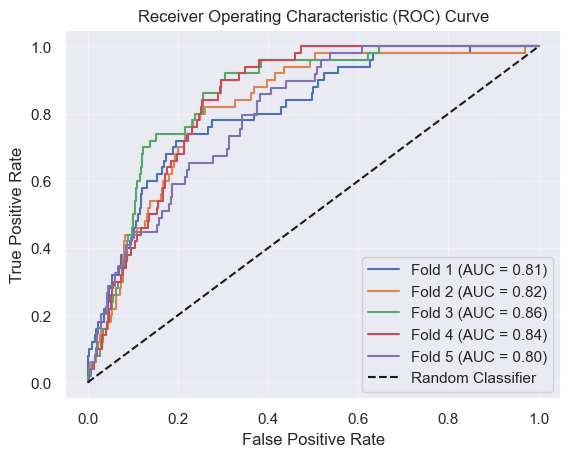

In [34]:
plt.figure()
fold = 0
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # ----------------------------  Standardizing/Scaling  ---------------------------------
    sc = StandardScaler()
    #create copies like in the tutorial to avoid inplace operations
    X_train_sc, X_test_sc = X_train.copy(), X_test.copy()

    X_train_sc[num_cols] = sc.fit_transform(X_train[num_cols])
    X_test_sc[num_cols] = sc.transform(X_test[num_cols])

    y_scores = log_reg_classifier.predict_proba(X_test_sc)[:, 1]

    # Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for the current fold
    plt.plot(fpr, tpr, label='Fold {} (AUC = {:.2f})'.format(fold+1, roc_auc))
    
    # increase counter for folds
    fold += 1

# Plot the random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle = "--", linewidth = 0.5, alpha = 0.7)


#save plot
plt.savefig("../output/roc_curve_log_reg.pdf", backend="pdf", dpi = 300, bbox_inches='tight')

# Show the plot
plt.show()

In [35]:
df_performance
#recall = sensitivity = true positive rate
#precision = proportion of true positive predicted values out of all positive predictions

,fold,clf,accuracy,precision,recall,specificity,F1
0,0,Logistic Regression,0.87182,0.800752,0.731959,0.927497,0.764811
1,1,Logistic Regression,0.867906,0.749091,0.757353,0.908,0.753199
2,2,Logistic Regression,0.867906,0.772727,0.75945,0.911081,0.766031
3,3,Logistic Regression,0.85225,0.786207,0.719243,0.912057,0.751236
4,4,Logistic Regression,0.873777,0.785714,0.777778,0.913103,0.781726


# Summarize the folds

In [31]:
print(df_performance.groupby(by = 'clf').agg(['mean', 'std']))

                    fold            accuracy           precision            \
                    mean       std      mean       std      mean       std   
clf                                                                          
Logistic Regression  2.0  1.581139  0.866732  0.008485  0.778898  0.019391   

                       recall           specificity                  F1  \
                         mean       std        mean       std      mean   
clf                                                                       
Logistic Regression  0.749157  0.023361    0.914347  0.007594  0.763401   

                               
                          std  
clf                            
Logistic Regression  0.012215  


In [33]:
display(all_importance)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0.114493,0.464582,0.093559,0.037517,0.029534,0.123374,0.079374,0.014843,0.042723
1,0.106211,0.441412,0.108068,0.087527,0.035417,0.110348,0.070571,0.004936,0.03551
2,0.092684,0.475805,0.110883,0.047894,0.034083,0.104563,0.077355,0.0074,0.049334
3,0.108493,0.460346,0.108911,0.050279,0.029092,0.112706,0.09179,0.000277,0.038105
4,0.121786,0.470675,0.086923,0.035405,0.044353,0.099,0.081819,0.016476,0.043564


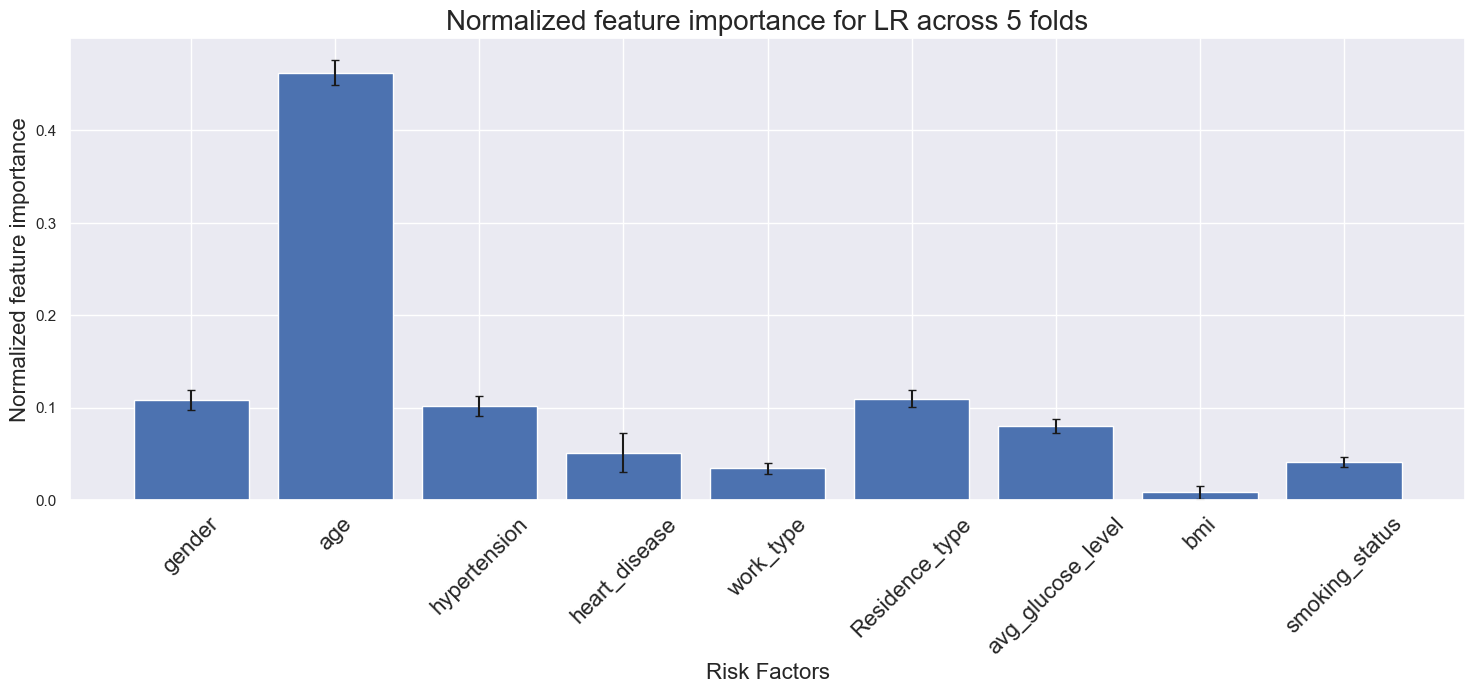

In [36]:
# Visualize the normalized feature importance across the five folds and add error bar to indicate the std
fig, ax = plt.subplots(figsize=(18, 6))

ax.bar(np.arange(importance_scores.shape[1]), all_importance.mean(), yerr=all_importance.std(), capsize=3)
ax.set_xticks(np.arange(importance_scores.shape[1]), X.columns.tolist(), rotation=45, fontsize=16)
ax.set_title("Normalized feature importance for LR across 5 folds", fontsize=20)
plt.xlabel('Risk Factors', fontsize=16)
plt.ylabel("Normalized feature importance", fontsize=16)
plt.savefig("../output/feature_importance_log_reg.pdf", backend="pdf", dpi = 300, bbox_inches='tight')
plt.show()

# Feature importance for Random Forest